In [1]:
import torch

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# UGATIT-Lite: Human → Anime Face Translator  
## 1. Overview
This project trains a **UGATIT-Lite** generative model to convert **real human faces → anime-style faces**.

We will:
- Build the full UGATIT-Lite architecture (Generator, Discriminator, AdaLIN)
- Train from scratch using two datasets:
  - **Human faces dataset**
  - **Anime faces dataset**
- Use mixed precision (AMP) for high performance
- Optimize the model
- Save results + logs + preview images

UGATIT is a state-of-the-art image-to-image translation model based on:
- **GANs**
- **Adaptive Layer-Instance Normalization (AdaLIN)**
- **CAM (Class Activation Map) attention**

UGATIT-Lite is a smaller, faster version optimized for quality *and* speed.

It performs:
**Human Face → Anime Face Conversion**

### Why Do We Need Two Datasets?

UGATIT is a **bi-directional** translation model.
It learns:

- Domain A = **Human faces**
- Domain B = **Anime faces**

- $G_{AB}$: human → anime
- $G_{BA}$: anime → human  
- $D_A$, $D_B$: discriminators for each domain

Without two datasets, the model cannot learn the mapping.

### UGATIT-Lite Architecture Overview

**Generators (2)**
- ResNet blocks  
- AdaLIN layers (adaptive instance + layer norm)
- CAM attention

**Discriminators (2)**
- PatchGAN style
- CAM attention

**Losses Used**
- GAN loss
- Cycle-consistency loss
- Identity loss
- CAM loss
- Reconstruction loss

## 2. Dataset Preparation

UGATIT requires two image domains:

### **Domain A — Human Faces**
- FFHQ 256×256  
- Clean, diverse, aligned

### **Domain B — Anime Faces**
- Danbooru Anime Faces  
- Faces only, consistent style

In this section we will:

1. Load raw datasets  
2. Remove corrupted images  
3. Ensure all images are RGB  
4. Resize to \(256 \times 256\)  
5. Normalize pixel values to \([-1,1]\)  
6. Save processed datasets  
7. Create PyTorch DataLoaders


In [2]:
# System & File Handling
import os
from tqdm import tqdm  # Progress bars for loops
import random

# Image Processing
from PIL import Image  # Image loading and saving
import numpy as np  # Array operations, image normalization
import matplotlib.pyplot as plt  # Visualization of images

# PyTorch / Deep Learning
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
import torch.nn.functional as F  # Functional operations (activations, etc.)
from torch.nn.utils import spectral_norm  # Spectral normalization for stability

# Data Handling & Augmentation
from torchvision import transforms  # Image transformations and augmentation
from torch.utils.data import Dataset, DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.utils import make_grid

In [3]:
# Set paths
raw_human_dir = "data/human/"
raw_anime_dir = "data/anime/"
processed_human_dir = "data/processed/trainA/"
processed_anime_dir = "data/processed/trainB/"
processed_flag = ".processed_flag"

# Image processing function
def process_images(input_dir, output_dir, size=256):
    files = os.listdir(input_dir)
    for f in tqdm(files, desc=f"Processing {input_dir}"):
        try:
            path = os.path.join(input_dir, f)
            img = Image.open(path).convert("RGB")
            img = img.resize((size, size), Image.BICUBIC)
            arr = (np.array(img).astype("float32") / 127.5) - 1.0
            out = ((arr + 1.0) * 127.5).astype(np.uint8)
            Image.fromarray(out).save(os.path.join(output_dir, f))
        except Exception as e:
            print(f"Skipping {f}: {e}")

# Only process once
if not os.path.exists(processed_flag):
    print("Processing dataset for the first time...")
    os.makedirs(processed_human_dir, exist_ok=True)
    os.makedirs(processed_anime_dir, exist_ok=True)
    
    process_images(raw_human_dir, processed_human_dir)
    process_images(raw_anime_dir, processed_anime_dir)

    # Create flag file
    with open(processed_flag, "w") as f:
        f.write("done")

    print("✅ Dataset processed and cached.")
else:
    print("⏩ Skipping preprocessing — dataset already prepared.")

⏩ Skipping preprocessing — dataset already prepared.


### PyTorch Dataset Class

The dataset loads:

- One human image (Domain A)
- One anime image (Domain B)

Both images are transformed to tensors and normalized.

In [4]:
class FaceAnimeDataset(Dataset):
    def __init__(self, human_dir, anime_dir, transform=None):
        self.human_files = sorted(os.listdir(human_dir))
        self.anime_files = sorted(os.listdir(anime_dir))
        self.human_dir = human_dir
        self.anime_dir = anime_dir
        self.transform = transform

    def __len__(self):
        return min(len(self.human_files), len(self.anime_files))

    def __getitem__(self, idx):
        human_path = os.path.join(self.human_dir, self.human_files[idx])
        anime_path = os.path.join(self.anime_dir, self.anime_files[idx])
        human = Image.open(human_path).convert("RGB")
        anime = Image.open(anime_path).convert("RGB")
        if self.transform:
            human = self.transform(human)
            anime = self.transform(anime)
        return human, anime

# Transform — lower resolution + augmentations
transform = transforms.Compose([
    transforms.Resize((128, 128)),           # reduce resolution
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Dataset & DataLoader
dataset = FaceAnimeDataset(processed_human_dir, processed_anime_dir, transform)
dataloader = DataLoader(
    dataset,
    batch_size=12,           
    shuffle=True,
    num_workers=0,          
    pin_memory=True,        # faster host → GPU transfer
)

print("Dataset size:", len(dataset))
print("Batches per epoch:", len(dataloader))

Dataset size: 52001
Batches per epoch: 4334


### Preview Samples
To visualize results, convert back from \([-1,1]\) to \([0,1]\):
$x_{\text{display}} = \frac{x + 1}{2}$

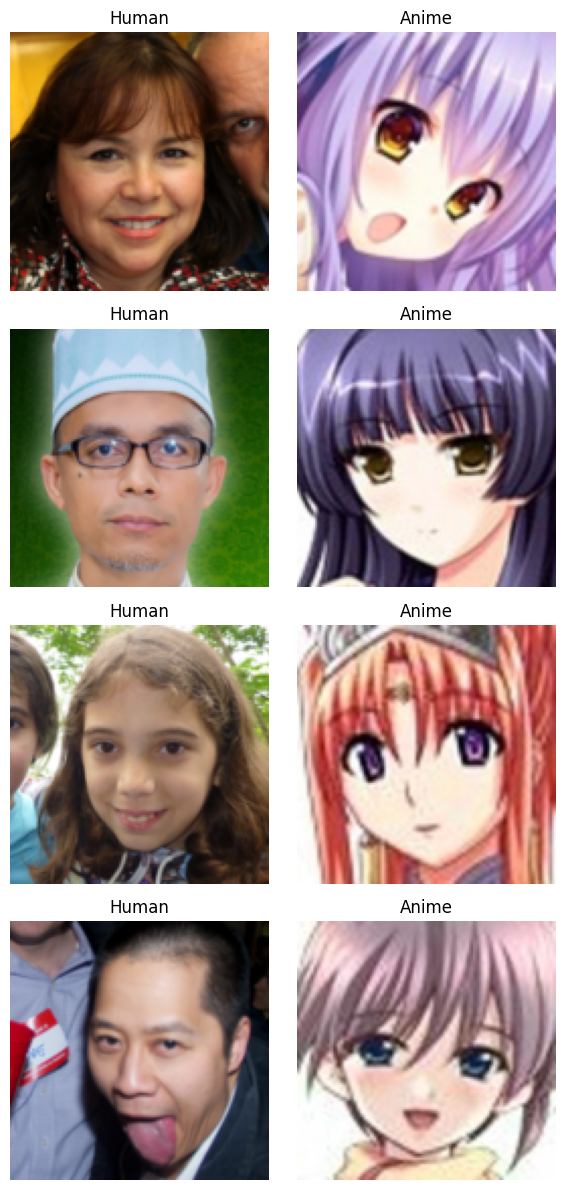

In [5]:
human_imgs, anime_imgs = next(iter(dataloader))

fig, axs = plt.subplots(4, 2, figsize=(6, 12))

for i in range(4):
    axs[i, 0].imshow(((human_imgs[i].permute(1, 2, 0).numpy() + 1)/2).clip(0,1))
    axs[i, 0].set_title("Human")
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(((anime_imgs[i].permute(1, 2, 0).numpy() + 1)/2).clip(0,1))
    axs[i, 1].set_title("Anime")
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()

## 3. Model Implementation (UGATIT-Lite)

UGATIT-Lite is an image-to-image translation network with:

- Generators: G_A2B (Human → Anime), G_B2A (Anime → Human)
- Discriminators: D_A (Human), D_B (Anime)
- Adaptive normalization (AdaILN)
- Class Activation Map (CAM) attention

We'll build **building blocks** first, then the **generators** and **discriminators**.

### Building Blocks

We need the following:

1. **ConvBlock** — Conv → Norm → Activation  
2. **ResBlock** — Residual block for deep features  
3. **ILN** — Instance-Layer Normalization  
4. **AdaILN** — Adaptive Instance-Layer Norm  
5. **CAM block** — Attention via global average + max pooling

In [6]:
# Convolutional block
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1, norm='in', activation='relu'):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding)
        
        if norm == 'in':
            self.norm = nn.InstanceNorm2d(out_ch, affine=True)
        elif norm == 'bn':
            self.norm = nn.BatchNorm2d(out_ch)
        else:
            self.norm = nn.Identity()
        
        if activation == 'relu':
            self.act = nn.ReLU(inplace=True)
        elif activation == 'lrelu':
            self.act = nn.LeakyReLU(0.2, inplace=True)
        else:
            self.act = nn.Identity()

    def forward(self, x):
        return self.act(self.norm(self.conv(x)))

# Residual block
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, norm='in', activation='relu'),
            ConvBlock(channels, channels, norm='in', activation='none')
        )

    def forward(self, x):
        return x + self.block(x)

In [7]:
class ILN(nn.Module):
    def __init__(self, channels, eps=1e-5):
        super().__init__()
        self.rho = nn.Parameter(torch.zeros(1, channels, 1, 1))
        self.gamma = nn.Parameter(torch.ones(1, channels, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, channels, 1, 1))
        self.eps = eps

    def forward(self, x):
        in_mean = x.mean([2,3], keepdim=True)
        in_var = x.var([2,3], keepdim=True)
        ln_mean = x.mean([1,2,3], keepdim=True)
        ln_var = x.var([1,2,3], keepdim=True)

        out = self.rho * ((x - in_mean) / torch.sqrt(in_var + self.eps)) + \
              (1 - self.rho) * ((x - ln_mean) / torch.sqrt(ln_var + self.eps))
        out = out * self.gamma + self.beta
        return out

class AdaILN(nn.Module):
    def __init__(self, channels, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.rho = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x, gamma, beta):
        in_mean = x.mean([2,3], keepdim=True)
        in_var = x.var([2,3], keepdim=True)
        ln_mean = x.mean([1,2,3], keepdim=True)
        ln_var = x.var([1,2,3], keepdim=True)

        out = self.rho * ((x - in_mean) / torch.sqrt(in_var + self.eps)) + \
              (1 - self.rho) * ((x - ln_mean) / torch.sqrt(ln_var + self.eps))
        out = out * gamma + beta
        return out

In [8]:
class CAMBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.gap_fc = nn.Linear(channels, 1, bias=False)
        self.gmp_fc = nn.Linear(channels, 1, bias=False)
        self.conv1x1 = nn.Conv2d(channels*2, channels, kernel_size=1, stride=1, bias=True)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        b, c, h, w = x.size()
        gap = F.adaptive_avg_pool2d(x, 1).view(b,c)
        gmp = F.adaptive_max_pool2d(x, 1).view(b,c)
        gap_logit = self.gap_fc(gap)
        gmp_logit = self.gmp_fc(gmp)
        gap_weight = list(self.gap_fc.parameters())[0]
        gmp_weight = list(self.gmp_fc.parameters())[0]
        gap = x * gap_weight.unsqueeze(2).unsqueeze(3)
        gmp = x * gmp_weight.unsqueeze(2).unsqueeze(3)
        cam = torch.cat([gap, gmp], dim=1)
        cam = self.relu(self.conv1x1(cam))
        return cam, gap_logit + gmp_logit

### Generators

We define **G_A2B** (Human → Anime) and **G_B2A** (Anime → Human).

Each generator:
- Downsampling layers  
- 4–6 ResBlocks  
- CAM attention  
- Up-convolution layers

In [9]:
class Generator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=4):
        super().__init__()
        self.down = nn.Sequential(
            ConvBlock(input_nc, ngf, 7, 1, 3, norm='in', activation='relu'),
            ConvBlock(ngf, ngf*2, 4, 2, 1, norm='in', activation='relu'),
            ConvBlock(ngf*2, ngf*4, 4, 2, 1, norm='in', activation='relu')
        )
        # Residual blocks
        res_blocks = []
        for _ in range(n_blocks):
            res_blocks.append(ResBlock(ngf*4))
        self.res_blocks = nn.Sequential(*res_blocks)

        self.cam = CAMBlock(ngf*4)

        # Up-sampling
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            ConvBlock(ngf*4, ngf*2, 3, 1, 1, norm='in', activation='relu'),
            nn.Upsample(scale_factor=2, mode='nearest'),
            ConvBlock(ngf*2, ngf, 3, 1, 1, norm='in', activation='relu'),
            nn.Conv2d(ngf, output_nc, 7, 1, 3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.down(x)
        x = self.res_blocks(x)
        x, cam_logit = self.cam(x)
        x = self.up(x)
        return x, cam_logit

### Discriminators

Two PatchGAN discriminators:

- D_A → Human  
- D_B → Anime  

Features:
- Multi-scale convolutional layers  
- Spectral normalization for stability  
- Outputs feature map for PatchGAN loss

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_nc=3, ndf=64):
        super().__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(input_nc, ndf, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(ndf, ndf*2, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(ndf*2, ndf*4, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(ndf*4, ndf*8, 4, 1, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, 4, 1, 1)  # PatchGAN output
        )

    def forward(self, x):
        return self.model(x)

## 4. Training Pipeline

This section defines the **full training loop** for UGATIT-Lite.

Key features:
- GAN loss using **LSGAN**
- Cycle-consistency loss
- Identity loss
- CAM loss for attention
- Optional perceptual & style loss for sharper anime features
- Adam optimizer with `lr=1e-4, betas=(0.5,0.999)`
- Mixed-precision training for speed
- Replay buffer to stabilize discriminators
- Checkpoints saved every 5 epochs

### Loss Functions

1. **GAN Loss (LSGAN)**

$$
\mathcal{L}_{GAN}(D, G) = \frac{1}{2} \mathbb{E}[(D(x)-1)^2] + \frac{1}{2}\mathbb{E}[D(G(z))^2]
$$

2. **Cycle-consistency Loss**

$$
\mathcal{L}_{cyc} = \lVert G_{B2A}(G_{A2B}(A)) - A \rVert_1 + \lVert G_{A2B}(G_{B2A}(B)) - B \rVert_1
$$

3. **Identity Loss**

$$
\mathcal{L}_{id} = \lVert G_{A2B}(B) - B \rVert_1 + \lVert G_{B2A}(A) - A \rVert_1
$$

4. **CAM Loss**  
Encourages generators to focus on important regions.

In [11]:
criterion_gan = nn.MSELoss()  # LSGAN
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

### Optimizers & AMP

- Generators and discriminators use **Adam**:

$$
\text{lr} = 1e-4, \quad \beta_1=0.5, \beta_2=0.999
$$

In [12]:
# Assume generators and discriminators are initialized
G_A2B = Generator().cuda()
G_B2A = Generator().cuda()
D_A = Discriminator().cuda()
D_B = Discriminator().cuda()

# Optimizers
g_params = list(G_A2B.parameters()) + list(G_B2A.parameters())
d_params = list(D_A.parameters()) + list(D_B.parameters())

optimizer_G = optim.Adam(g_params, lr=1e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(d_params, lr=1e-4, betas=(0.5, 0.999))

# Mixed precision scaler
scaler = GradScaler("cuda")

### Replay Buffer

- Stabilizes discriminator training by storing a **buffer of previously generated images**
- Mixes old and new fake images during discriminator updates

In [13]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for img in data:
            img = img.unsqueeze(0)
            if len(self.data) < self.max_size:
                self.data.append(img)
                to_return.append(img)
            else:
                if random.random() > 0.5:
                    idx = random.randint(0, self.max_size-1)
                    tmp = self.data[idx].clone()
                    self.data[idx] = img
                    to_return.append(tmp)
                else:
                    to_return.append(img)
        return torch.cat(to_return, 0)

### Training Steps per Batch

For each batch:
1. Forward: A→fake_B, B→fake_A
2. Forward: fake_B→rec_A, fake_A→rec_B (cycle)
3. Forward: A→id_A, B→id_B (identity)
4. Compute generator losses (GAN, cycle, identity, CAM)
5. Backprop generator with AMP
6. Forward discriminators on real and fake
7. Compute discriminator losses
8. Backprop discriminator
9. Update optimizers
10. Save samples & log

In [14]:
num_epochs = 100
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)
latest_checkpoint = os.path.join(save_dir, "latest.pth")

# Replay buffers
replay_buffer_A = ReplayBuffer()
replay_buffer_B = ReplayBuffer()

ID_LOSS_FREQUENCY = 10  # Compute identity loss every 10 steps

# Resume from checkpoint if exists
start_epoch = 1
if os.path.exists(latest_checkpoint):
    print("Loading checkpoint...")
    checkpoint = torch.load(latest_checkpoint)
    G_A2B.load_state_dict(checkpoint["G_A2B"])
    G_B2A.load_state_dict(checkpoint["G_B2A"])
    D_A.load_state_dict(checkpoint["D_A"])
    D_B.load_state_dict(checkpoint["D_B"])
    optimizer_G.load_state_dict(checkpoint["opt_G"])
    optimizer_D.load_state_dict(checkpoint["opt_D"])
    start_epoch = checkpoint.get("epoch", 1) + 1
else:
    print("No checkpoint found, starting from scratch.")

# Only train if we haven't reached the final epoch
if start_epoch <= num_epochs:
    for epoch in range(start_epoch, num_epochs + 1):
        loop = tqdm(dataloader, desc=f"Epoch [{epoch}/{num_epochs}]")
        
        for step, (real_A, real_B) in enumerate(loop):
            real_A = real_A.cuda(non_blocking=True)
            real_B = real_B.cuda(non_blocking=True)

            # -------------------
            # Train Generators
            # -------------------
            optimizer_G.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda"):  # mixed precision
                # Forward pass through generators
                fake_B, _ = G_A2B(real_A)      # Human -> Anime
                fake_A, _ = G_B2A(real_B)      # Anime -> Human
            
                # Cycle-consistency
                rec_A, _ = G_B2A(fake_B)       # Anime -> Human
                rec_B, _ = G_A2B(fake_A)       # Human -> Anime
            
                # GAN loss
                loss_GAN = (
                    criterion_gan(D_B(fake_B), torch.ones_like(D_B(fake_B))) +
                    criterion_gan(D_A(fake_A), torch.ones_like(D_A(fake_A)))
                )
            
                # Cycle loss
                loss_cycle = (
                    criterion_cycle(rec_A, real_A) +
                    criterion_cycle(rec_B, real_B)
                ) * 10.0
            
                # Identity loss (optional: every N steps)
                if step % ID_LOSS_FREQUENCY == 0:
                    id_A, _ = G_B2A(real_A)
                    id_B, _ = G_A2B(real_B)
                    loss_id = (
                        criterion_identity(id_A, real_A) +
                        criterion_identity(id_B, real_B)
                    ) * 5.0
                else:
                    loss_id = 0.0
            
                # Total generator loss
                loss_G = loss_GAN + loss_cycle + loss_id
            
            scaler.scale(loss_G).backward()
            scaler.step(optimizer_G)

            # -------------------
            # Train Discriminators
            # -------------------
            optimizer_D.zero_grad(set_to_none=True)
            
            with torch.amp.autocast("cuda"):
                # Detach fake images before using in discriminator
                fake_A_buffer = replay_buffer_A.push_and_pop(fake_A.detach())
                fake_B_buffer = replay_buffer_B.push_and_pop(fake_B.detach())
            
                # Real predictions
                pred_real_A = D_A(real_A)
                pred_real_B = D_B(real_B)
            
                # Fake predictions (from buffer)
                pred_fake_A = D_A(fake_A_buffer)
                pred_fake_B = D_B(fake_B_buffer)
            
                # LSGAN loss
                loss_D_A = 0.5 * (
                    criterion_gan(pred_real_A, torch.ones_like(pred_real_A)) +
                    criterion_gan(pred_fake_A, torch.zeros_like(pred_fake_A))
                )
                loss_D_B = 0.5 * (
                    criterion_gan(pred_real_B, torch.ones_like(pred_real_B)) +
                    criterion_gan(pred_fake_B, torch.zeros_like(pred_fake_B))
                )
            
                loss_D = loss_D_A + loss_D_B
            
            scaler.scale(loss_D).backward()
            scaler.step(optimizer_D)
            scaler.update()

            loop.set_postfix(G=loss_G.item(), D=loss_D.item())

        # Save checkpoint every 5 epochs or at last epoch
        if epoch % 5 == 0 or epoch == num_epochs:
            torch.save({
                "epoch": epoch,
                "G_A2B": G_A2B.state_dict(),
                "G_B2A": G_B2A.state_dict(),
                "D_A": D_A.state_dict(),
                "D_B": D_B.state_dict(),
                "opt_G": optimizer_G.state_dict(),
                "opt_D": optimizer_D.state_dict(),
            }, latest_checkpoint)
            print(f"Checkpoint saved at epoch {epoch}")
else:
    print("Training already completed. Loading final model...")

Loading checkpoint...
Training already completed. Loading final model...


## 5. Evaluation & Visualization

In this section, we:
- Visualize generated images (Human → Anime, Anime → Human)
- Check cycle consistency (Human → Anime → Human)
- Plot training curves (Generator/Discriminator/Cycle losses)
- Compute the FID score

### Load Trained Models for Evaluation
In this section, we load the trained CycleGAN generators (`G_A2B` and `G_B2A`) from the checkpoint that we saved during training.

In [15]:
# Load trained generators from checkpoint
G_A2B = Generator().to(device)
G_B2A = Generator().to(device)

# ----- Load checkpoint -----
ckpt_path = "checkpoints/latest.pth"
checkpoint = torch.load(ckpt_path, map_location=device)

G_A2B.load_state_dict(checkpoint["G_A2B"])
G_B2A.load_state_dict(checkpoint["G_B2A"])

G_A2B.eval()
G_B2A.eval()

print("Loaded trained generators.")

Loaded trained generators.


### Display Results

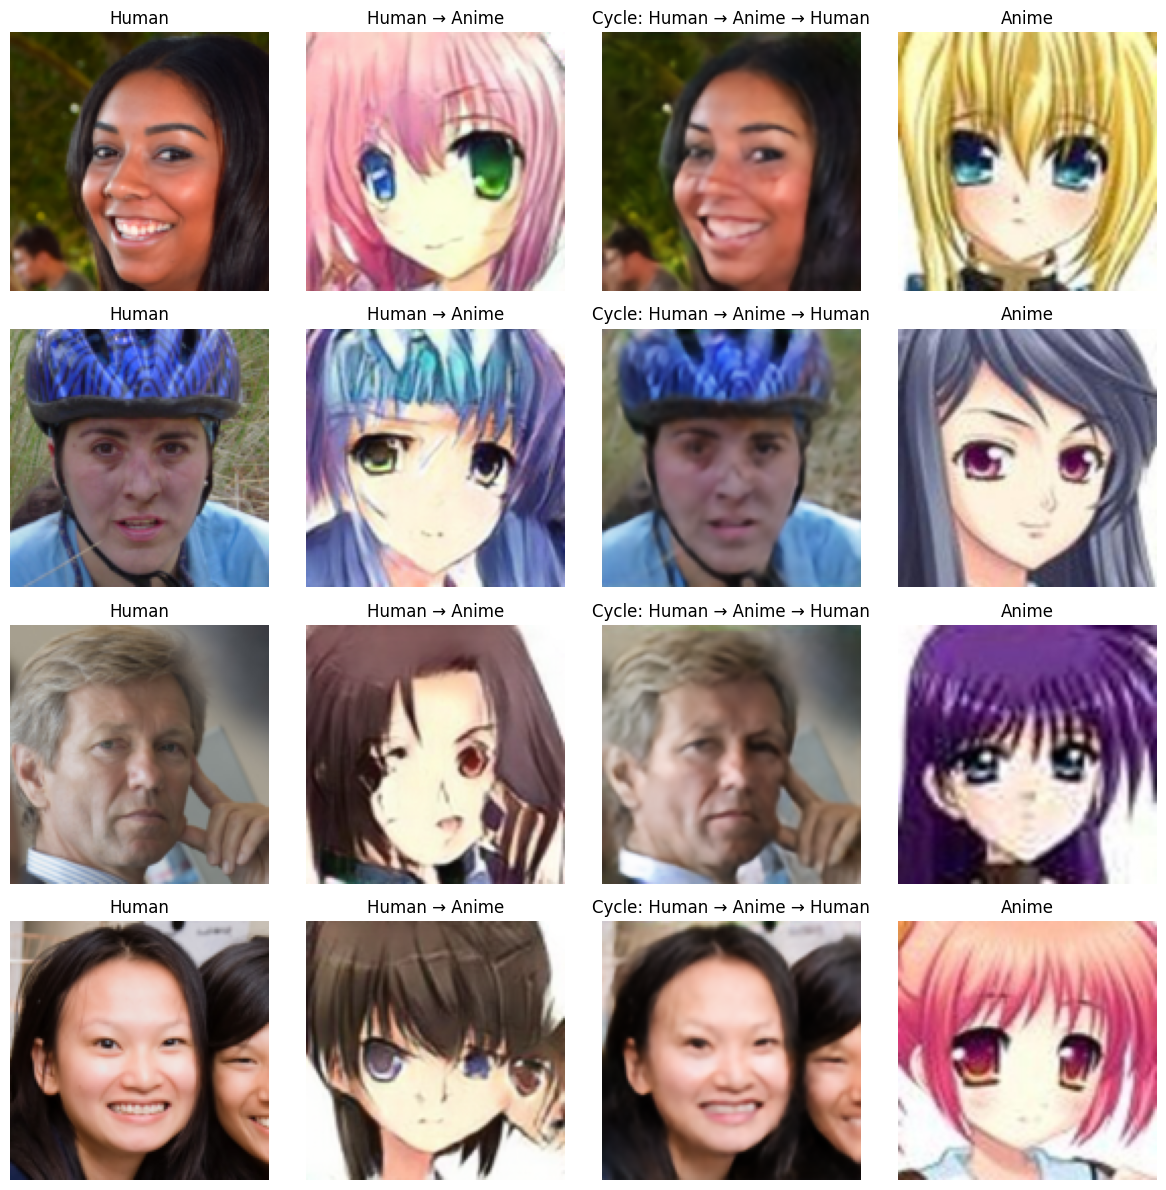

In [16]:
# Load a batch of images from the dataset
human_imgs, anime_imgs = next(iter(dataloader))
human_imgs = human_imgs.to(device)
anime_imgs = anime_imgs.to(device)

# Generate outputs
with torch.no_grad():
    fake_anime, _ = G_A2B(human_imgs)
    fake_human, _ = G_B2A(anime_imgs)
    cycle_human, _ = G_B2A(fake_anime)
    cycle_anime, _ = G_A2B(fake_human)

# Function to denormalize
def denorm(img):
    return ((img.cpu().permute(1,2,0).numpy() + 1)/2).clip(0,1)

# Plot a few examples
fig, axs = plt.subplots(4, 4, figsize=(12,12))

for i in range(4):
    axs[i,0].imshow(denorm(human_imgs[i]))
    axs[i,0].set_title("Human")
    axs[i,0].axis("off")

    axs[i,1].imshow(denorm(fake_anime[i]))
    axs[i,1].set_title("Human → Anime")
    axs[i,1].axis("off")

    axs[i,2].imshow(denorm(cycle_human[i]))
    axs[i,2].set_title("Cycle: Human → Anime → Human")
    axs[i,2].axis("off")

    axs[i,3].imshow(denorm(anime_imgs[i]))
    axs[i,3].set_title("Anime")
    axs[i,3].axis("off")

plt.tight_layout()
plt.show()

### FID Evaluation

We will calculate the **Fréchet Inception Distance (FID)** score to quantitatively evaluate how close the generated anime images are to the real anime images.

- Lower FID indicates better quality and distribution similarity.
- This will evaluate our `G_A2B` generator (Human → Anime).

In [17]:
def calculate_fid(generator, dataloader, device):
    """
    Calculate FID between real anime images and generated anime images.
    generator: Human->Anime generator (G_A2B)
    dataloader: DataLoader providing batches of human & anime images
    device: 'cuda' or 'cpu'
    """
    fid = FrechetInceptionDistance(feature=2048).to(device)

    generator.eval()
    with torch.no_grad():
        for human_imgs, anime_imgs in tqdm(dataloader, desc="Calculating FID"):
            human_imgs = human_imgs.to(device)
            anime_imgs = anime_imgs.to(device)

            # Generate fake anime
            fake_anime, _ = generator(human_imgs)

            # Convert images to uint8 [0, 255]
            real_imgs_uint8 = ((anime_imgs + 1) * 127.5).clamp(0, 255).to(torch.uint8)
            fake_imgs_uint8 = ((fake_anime + 1) * 127.5).clamp(0, 255).to(torch.uint8)
            
            fid.update(real_imgs_uint8, real=True)
            fid.update(fake_imgs_uint8, real=False)

    score = fid.compute()
    return score.item()
fid_path = "fid_score.json"

# If FID file exists, load and skip computation
if os.path.exists(fid_path):
    with open(fid_path, "r") as f:
        fid_score = json.load(f)["fid"]
    print(f"[Loaded Saved FID] FID score (Human → Anime): {fid_score:.2f}")
else:
    # Run expensive computation only once
    fid_score = calculate_fid(G_A2B, dataloader, device)
    print(f"[Computed FID] FID score (Human → Anime): {fid_score:.2f}")

    # Save result
    with open(fid_path, "w") as f:
        json.dump({"fid": fid_score}, f)
    print("FID score saved → fid_score.json")

[Loaded Saved FID] FID score (Human → Anime): 21.87


The FID score above gives us a quantitative measure of our model's performance:

- **Score ≈ 21.87** → This is a decent result, indicating that generated anime faces are fairly similar to real anime faces.
- Lower FID scores are better; scores below 30 are typically considered good for custom datasets.

Next, we can visualize some **generated samples** to qualitatively assess the results.

## 6. Gradio Web App — Human → Anime Converter

This section creates an interactive **Gradio web demo** that allows users to:

- Upload a real human face  
- Convert it into anime style using our trained `G_A2B` generator  
- Download the generated anime image  
- Toggle between **Fast Mode** and **Quality Mode** (if EMA weights available)

This is ideal for deploying on **Hugging Face Spaces** or sharing locally.

**Pipeline:**

1. Load the trained generator (`G_A2B.pth`)
2. Preprocess user image → normalized tensor
3. Run inference
4. Post-process → convert back into a PIL image
5. Display + enable download

In [ ]:
import gradio as gr
from torchvision import transforms

# -----------------------------------------------------
# Load Generator
# -----------------------------------------------------
ckpt_path = "checkpoints/latest.pth"
checkpoint = torch.load(ckpt_path, map_location=device)

G_A2B = Generator().to(device)
G_A2B.load_state_dict(checkpoint["G_A2B"])
G_A2B.eval()

print("Loaded G_A2B from checkpoints/latest.pth")

# -----------------------------------------------------
# Preprocessing & Postprocessing
# -----------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

def tensor_to_pil(tensor_img):
    img = tensor_img.detach().cpu()
    img = (img * 0.5 + 0.5).clamp(0, 1)
    return transforms.ToPILImage()(img)

# -----------------------------------------------------
# Inference Function
# -----------------------------------------------------
def convert_to_anime(image, use_ema):
    if image is None:
        return None

    # Use the correct transform variable
    img_tensor = transform(image).unsqueeze(0).to(device)
    
    # Currently we only have G_A2B
    generator = G_A2B  # No EMA for now
    generator.eval()

    with torch.no_grad():
        output = generator(img_tensor)

        # Unpack tuple output from UGATIT/Generator
        if isinstance(output, tuple):
            output = output[0]

        output = output.squeeze(0)
        output_img = tensor_to_pil(output)

    return output_img

# -----------------------------------------------------
# Gradio Interface
# -----------------------------------------------------
title = "Human → Anime Generator (UGATIT-Lite)"
description = "Upload a real face and get an anime-style version."

interface = gr.Interface(
    fn=convert_to_anime,
    inputs=[
        gr.Image(type="pil", label="Upload Human Face"),
        gr.Checkbox(label="Quality Mode (EMA)", value=False)
    ],
    outputs=gr.Image(type="pil", label="Anime Output"),
    title=title,
    description=description,
)

interface.launch(debug=True)

Loaded G_A2B from checkpoints/latest.pth
* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.
